In [153]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Optional, Dict, Any, Iterable

import numpy as np
import pandas as pd


# =============================================================================
# 1) Schema & normalization
# =============================================================================

erp_cols = {
    "document_number": "document_number",
    "debit_credit": "debit_credit",
    "date": "date",
    "amount": "amount",
    "quantity": "quantity",
    "account_name": "account_id",
    "product_id": "product_id",
    "procurement_id": "procurement_id",
    "service_id": "service_id",
    "vendor_name": "vendor_id",
    "customer_name": "customer_id",
}

@dataclass(frozen=True)
class Schema:
    mapping: Dict[str, str]

    @property
    def inverse(self) -> Dict[str, str]:
        return {v: k for k, v in self.mapping.items()}

    # canonical names (helpers to avoid string literals all over)
    @property
    def document_number(self): return "document_number"
    @property
    def debit_credit(self):    return "debit_credit"
    @property
    def date(self):            return "date"
    @property
    def amount(self):          return "amount"
    @property
    def quantity(self):        return "quantity"
    @property
    def account_id(self):      return "account_id"
    @property
    def product_id(self):      return "product_id"
    @property
    def procurement_id(self):  return "procurement_id"
    @property
    def service_id(self):      return "service_id"
    @property
    def vendor_id(self):       return "vendor_id"
    @property
    def customer_id(self):     return "customer_id"

S = Schema(mapping=erp_cols)


def normalize_df(df: pd.DataFrame, schema: Schema = S) -> pd.DataFrame:
    """
    Rename raw/source → canonical, but *skip* a rename if it would
    overwrite an existing canonical column (avoids duplicate labels).
    """
    ren = {}
    for raw, canon in schema.mapping.items():
        if raw in df.columns:
            # If target canonical already exists, skip this rename
            # (e.g., raw='account_name', canon='account_id' while 'account_id' already present)
            if canon in df.columns and canon != raw:
                continue
            ren[raw] = canon
    return df.rename(columns=ren)


def denormalize_df(df: pd.DataFrame, schema: Schema = S) -> pd.DataFrame:
    """Rename canonical -> original raw names (if needed)."""
    inv = schema.inverse
    return df.rename(columns={k: v for k, v in inv.items() if k in df.columns})


def coalesce_duplicate_named_columns(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """
    If df has multiple columns named 'name', merge them left→right (first non-null),
    keep a single column.
    """
    import numpy as np
    # find *all* columns with exact same label
    idx = np.where(np.array(df.columns) == name)[0]
    if len(idx) <= 1:
        return df

    merged = df.iloc[:, idx].bfill(axis=1).iloc[:, 0]
    out = df.drop(df.columns[idx[1:]], axis=1).copy()
    out[name] = merged
    return out

# =============================================================================
# 2) Date helpers (fast & simple)
# =============================================================================

def generate_dim_date(
    year_start: int = 2020,
    year_end: int = 2025,
    business_days_only: bool = True,
) -> pd.DataFrame:
    """Create a simple date dimension with a 'date' column."""
    start = f"{year_start}-01-01"
    end = f"{year_end}-12-31"
    if business_days_only:
        dates = pd.bdate_range(start, end)
    else:
        dates = pd.date_range(start, end, freq="D")
    return pd.DataFrame({"date": pd.to_datetime(dates)})


def sample_dates(
    df_date: pd.DataFrame,
    size: int,
    *,
    ensure_quarter_balance: bool = False,
    rng: Optional[np.random.Generator] = None,
) -> np.ndarray:
    """
    Fast date sampler. If ensure_quarter_balance=True, tries to pick ~equal
    amount from each quarter. Otherwise, uniform sampling.
    """
    if rng is None:
        rng = np.random.default_rng(123)
    arr = pd.to_datetime(df_date["date"]).to_numpy()
    if size <= 0:
        return np.array([], dtype="datetime64[ns]")

    if not ensure_quarter_balance:
        return rng.choice(arr, size=size, replace=True)

    # Stratify by quarter (approx equal per quarter)
    df = pd.DataFrame({"date": arr})
    q = pd.PeriodIndex(df["date"], freq="Q")
    groups = {k: v["date"].to_numpy() for k, v in df.groupby(q)}

    # compute roughly equal allocation
    n_quarters = max(1, len(groups))
    base = size // n_quarters
    rem = size - base * n_quarters

    picks: list[np.ndarray] = []
    keys = list(groups.keys())
    for i, key in enumerate(keys):
        ksz = base + (1 if i < rem else 0)
        pool = groups[key]
        if pool.size == 0:
            continue
        picks.append(rng.choice(pool, size=ksz, replace=True))

    if len(picks) == 0:
        return rng.choice(arr, size=size, replace=True)

    out = np.concatenate(picks)
    # shuffle for randomness
    rng.shuffle(out)
    return out


# =============================================================================
# 3) Target doc value helper (adaptive realism from unit_price)
# =============================================================================

def compute_target_doc_value_per_item(
    df: pd.DataFrame,
    *,
    unit_price_col: str = "unit_price",
    max_lines_per_doc: int = 25,
    cap_factor: float = 1.15,
    min_doc_value: float = 5_000,
    cheap_expensive_log10: tuple[float, float] = (3.0, 6.0),  # 10^3..10^6 price band
    lines_for_band: tuple[int, int] = (12, 2),                # cheap→12 lines, expensive→2 lines
) -> pd.DataFrame:
    """
    Adds:
      - desired_lines (int),
      - target_doc_value (float),
      - doc_value_cap (float)
    """
    out = df.copy()
    u = pd.to_numeric(out[unit_price_col], errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(1.0).clip(lower=1.0)
    logu = np.log10(u)

    lo, hi = cheap_expensive_log10
    l_lo, l_hi = lines_for_band
    desired_lines = np.interp(logu, [lo, hi], [l_lo, l_hi])
    desired_lines = np.clip(np.round(desired_lines), 1, max_lines_per_doc).astype(int)

    target_doc_value = u * desired_lines
    doc_value_cap = cap_factor * u * max_lines_per_doc

    target_doc_value = np.clip(target_doc_value, min_doc_value, doc_value_cap)

    out["desired_lines"] = desired_lines
    out["target_doc_value"] = np.round(target_doc_value, 2)
    out["doc_value_cap"] = np.round(doc_value_cap, 2)
    return out


# =============================================================================
# 4) Fast: assign number of docs & lines (vectorized)
# =============================================================================

def fast_assign_counts(
    df: pd.DataFrame,
    *,
    max_lines_per_doc: int = 25,
    cap_factor: float = 1.15,
    rng: Optional[np.random.Generator] = None,
    total_cols: Iterable[str] = ("total_amount", "annual_spend", "total_ammount", "total"),
) -> pd.DataFrame:
    """
    Computes:
      - n_docs
      - avg_lines_per_doc
      - doc_value_cap
      - target_doc_value (if not already present)
    """
    if rng is None:
        rng = np.random.default_rng(42)

    out = df.copy()

    # Pick a total column
    amt_col = next((c for c in total_cols if c in out.columns), None)
    if amt_col is None:
        raise ValueError("Need a total amount column (e.g., 'annual_spend').")
    if "unit_price" not in out.columns:
        raise ValueError("Missing 'unit_price'.")

    total = pd.to_numeric(out[amt_col], errors="coerce").fillna(0.0).clip(lower=0.0).to_numpy()
    unit  = pd.to_numeric(out["unit_price"], errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(1.0).clip(lower=1.0).to_numpy()

    # doc cap
    doc_cap = cap_factor * unit * max_lines_per_doc

    # target doc value (use existing if present, else compute adaptive)
    if "target_doc_value" in out.columns:
        tgt = pd.to_numeric(out["target_doc_value"], errors="coerce").replace([np.inf, -np.inf], np.nan)
        tgt = tgt.to_numpy()
        # sanitize & clip
        tgt = np.where(np.isfinite(tgt) & (tgt > 0), tgt, np.nan)
    else:
        tmp = compute_target_doc_value_per_item(out, max_lines_per_doc=max_lines_per_doc, cap_factor=cap_factor)
        out[["desired_lines", "target_doc_value", "doc_value_cap"]] = tmp[["desired_lines", "target_doc_value", "doc_value_cap"]]
        tgt = out["target_doc_value"].to_numpy()

    tgt = np.clip(np.nan_to_num(tgt, nan=(doc_cap / 2.0)), 1.0, doc_cap)

    # docs: ceil(total / tgt); feasibility: at least total/doc_cap
    base_docs = np.ceil(np.divide(total, tgt, out=np.zeros_like(total), where=tgt > 0)).astype(int)
    min_docs  = np.ceil(np.divide(total, doc_cap, out=np.ones_like(total), where=doc_cap > 0)).astype(int)
    n_docs    = np.maximum(base_docs, min_docs)
    n_docs    = np.clip(n_docs, 1, None)

    # avg lines per doc: ceil(total units / n_docs), bounded
    est_total_lines = np.ceil(total / unit).astype(int)
    est_total_lines[~np.isfinite(est_total_lines)] = 1
    est_total_lines = np.clip(est_total_lines, 1, None)

    avg_lines_per_doc = np.ceil(est_total_lines / n_docs).astype(int)
    avg_lines_per_doc = np.clip(avg_lines_per_doc, 1, max_lines_per_doc)

    out["n_docs"] = n_docs
    out["avg_lines_per_doc"] = avg_lines_per_doc
    out["doc_value_cap"] = np.round(doc_cap, 2)
    # ensure target_doc_value is present
    if "target_doc_value" not in out.columns:
        out["target_doc_value"] = np.round(tgt, 2)

    return out


# =============================================================================
# 5) Fast: explode into documents (multinomial cents split)
# =============================================================================

def fast_make_doc_plan(
    df: pd.DataFrame,
    *,
    rng=None,
    df_date=None,
    ensure_quarter_balance=True,
    total_cols=("total_amount","annual_spend","total_ammount","total"),
    target_qty_per_line: float = 4.0,
    qty_sigma: float = 0.6,        # ← NEW: variability for target qty (lognormal)
) -> pd.DataFrame:
    
    if rng is None:
        rng = np.random.default_rng(43)
    """
    Returns a per-document plan with:
      item_name, source_type, date, doc_value, n_lines, unit_price, IDs...
    """
    if rng is None:
        rng = np.random.default_rng(43)

    # pick totals
    amt_col = next((c for c in total_cols if c in df.columns), None)
    if amt_col is None:
        raise ValueError("Need a total amount column (e.g., 'annual_spend').")
    if "n_docs" not in df.columns or "avg_lines_per_doc" not in df.columns:
        raise ValueError("Run fast_assign_counts first.")

    n_docs = df["n_docs"].to_numpy().astype(int)
    idx_rep = np.repeat(np.arange(len(df)), n_docs)
    plan = df.iloc[idx_rep].copy()

    # multinomial cents split per item
    totals_cents = (pd.to_numeric(df[amt_col], errors="coerce").fillna(0.0).clip(lower=0.0).to_numpy() * 100).astype(int)
    cents_blocks = [
        rng.multinomial(t, np.ones(nd) / nd) if nd > 0 else np.zeros(1, dtype=int)
        for t, nd in zip(totals_cents, n_docs)
    ]
    doc_cents = np.concatenate(cents_blocks)
    plan["doc_value"] = doc_cents / 100.0
    
    # lines per doc: use target_qty_per_line to reduce lines, then clamp
    unit = pd.to_numeric(plan["unit_price"], errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(1.0).clip(lower=1.0).to_numpy()
    avg_lines_cap = plan["avg_lines_per_doc"].to_numpy().astype(int)
    dv = plan["doc_value"].to_numpy()

    # variable target qty per doc (lognormal multiplier)
    # ln(Z) ~ N(0, qty_sigma^2) → E[Z]=exp(0.5*qty_sigma^2)
    z = rng.lognormal(mean=0.0, sigma=qty_sigma, size=len(plan))
    tq = np.maximum(1.0, target_qty_per_line * z)

    # expected lines for each doc
    lam = np.maximum(1.0, dv / (unit * tq))
    # sample Poisson around that expectation (min 1, then cap)
    n_lines = np.clip(rng.poisson(lam=lam).astype(int), 1, avg_lines_cap)
    plan["n_lines"] = n_lines

    # dates
    if df_date is None:
        df_date = generate_dim_date(2020, 2025)
    plan["date"] = sample_dates(df_date, size=len(plan), ensure_quarter_balance=ensure_quarter_balance, rng=rng)

    keep = [
        "item_name", "source_type", "date", "doc_value", "n_lines", "unit_price",
        "product_id", "procurement_id", "service_id"
    ]
    keep = [c for c in keep if c in plan.columns]
    
    return plan[keep].reset_index(drop=True)


# =============================================================================
# 6) Fast: mapping index + materialize lines (vectorized-ish)
# =============================================================================

def build_mapping_index(
    df_mapping: pd.DataFrame,
    *,
    schema: Schema = S,
    passthrough: tuple[str, ...] = ("vendor_name", "bu_id"),  # add more if you like
) -> dict:
    dfm = df_mapping.copy()
    # Safety: coalesce if duplicates slipped through
    dfm = coalesce_duplicate_named_columns(dfm, schema.account_id)

    if "item_name" not in dfm.columns:
        raise ValueError("df_mapping must contain 'item_name'.")
    if schema.account_id not in dfm.columns:
        raise ValueError(f"df_mapping must contain canonical '{schema.account_id}'.")

    # keep only columns we need for the index
    keep_cols = ["item_name", schema.account_id] + [c for c in passthrough if c in dfm.columns]
    dfm = dfm[keep_cols]

    index: dict = {}
    for name, g in dfm.groupby("item_name", sort=False):
        entry = {schema.account_id: g[schema.account_id].to_numpy()}
        for col in passthrough:
            if col in g.columns:
                entry[col] = g[col].to_numpy()
        index[name] = entry
    return index


def fast_materialize_lines(
    plan: pd.DataFrame,
    mapping_index: dict,
    *,
    rng=None,
    schema=S,
    qty_line_sigma: float = 0.5,   
    min_qty: float = 1.0,
    max_qty: float | None = None,  # e.g., 50 or None
) -> pd.DataFrame:
    
    if rng is None:
        rng = np.random.default_rng(44)

    n_lines_per_doc = plan["n_lines"].to_numpy().astype(int)
    idx_rep = np.repeat(np.arange(len(plan)), n_lines_per_doc)
    lines = plan.iloc[idx_rep].copy().reset_index(drop=True)

    # --- split values into lines (keep your multinomial on cents) ---
    doc_cents = (plan["doc_value"].to_numpy() * 100).astype(int)
    cents_blocks = [
        rng.multinomial(c, np.ones(k)/k) if k > 0 else np.array([0], int)
        for c, k in zip(doc_cents, n_lines_per_doc)
    ]
    line_cents = np.concatenate(cents_blocks)
    amounts = line_cents / 100.0

    # --- sign & D/C ---
    st = lines.get("source_type", "").astype(str).str.lower().to_numpy()
    sign = np.where(np.isin(st, ["service","procurement","overhead"]), -1.0, 1.0)
    amounts *= sign
    lines[schema.amount] = amounts

    # --- quantity with line-level randomness ---
    unit = pd.to_numeric(lines.get("unit_price", 1.0), errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(1.0).clip(lower=1.0).to_numpy()
    # multiplicative noise per line
    qnoise = rng.lognormal(mean=0.0, sigma=qty_line_sigma, size=len(lines))
    raw_qty = np.abs(amounts) / np.maximum(unit, 1.0) * qnoise
    qty = np.ceil(np.clip(raw_qty, min_qty, max_qty if max_qty is not None else np.inf))
    lines[schema.quantity] = qty

    lines[schema.debit_credit] = np.where(amounts >= 0, "Credit", "Debit")

    # --- mapping assignment (account_id + passthroughs) ---
    item_arr = lines["item_name"].to_numpy()
    acc = np.empty(len(lines), dtype=object)

    # discover which extra fields exist in the index
    extra_cols = set()
    for entry in mapping_index.values():
        extra_cols.update(k for k in entry.keys() if k != schema.account_id)
    extra_cols = list(extra_cols)
    extra_vals = {c: np.empty(len(lines), dtype=object) for c in extra_cols}

    groups = pd.Series(np.arange(len(lines))).groupby(item_arr)
    for name, idxs in groups:
        idxs = idxs.values
        pool = mapping_index.get(name)
        if not pool or len(pool[schema.account_id]) == 0:
            acc[idxs] = None
            for c in extra_cols: extra_vals[c][idxs] = None
            continue
        k = len(pool[schema.account_id])
        sel = rng.integers(0, k, size=len(idxs))
        acc[idxs] = pool[schema.account_id][sel]
        for c in extra_cols:
            extra_vals[c][idxs] = pool.get(c, np.array([None]))[sel] if c in pool else None

    lines[schema.account_id] = acc
    for c in extra_cols:
        lines[c] = extra_vals[c]

    keep = [
        "date", schema.amount, schema.quantity, schema.debit_credit, schema.account_id,
        "item_name", "source_type", "unit_price",
        # your IDs if present in plan:
        schema.product_id, schema.procurement_id, schema.service_id,
        # passthroughs:
        "vendor_name", "bu_id",
    ]
    keep = [c for c in keep if c in lines.columns]
    return lines[keep]


# =============================================================================
# 7) Metadata (doc numbers, currency) + balancing
# =============================================================================

def assign_document_numbers_and_currency(
    df_lines: pd.DataFrame,
    df_document_metadata: Optional[pd.DataFrame],
    *,
    rng: Optional[np.random.Generator] = None,
    schema: Schema = S,
) -> pd.DataFrame:
    """Assign document_number and currency in one vectorized pass."""
    if rng is None:
        rng = np.random.default_rng(46)

    out = df_lines.copy()

    # currency pool
    if df_document_metadata is not None and "currency" in df_document_metadata.columns:
        cur_pool = df_document_metadata["currency"].dropna().to_numpy()
        if cur_pool.size == 0:
            cur_pool = np.array(["EUR", "USD", "DKK"])
    else:
        cur_pool = np.array(["EUR", "USD", "DKK"])

    out["currency"] = rng.choice(cur_pool, size=len(out), replace=True)

    # document number pool
    if df_document_metadata is not None and schema.document_number in df_document_metadata.columns:
        doc_pool = df_document_metadata[schema.document_number].dropna().astype(str).to_numpy()
        if doc_pool.size == 0:
            doc_pool = np.array([f"DOC-{i:06d}" for i in range(max(1, len(out) // 10))])
    else:
        doc_pool = np.array([f"DOC-{i:06d}" for i in range(max(1, len(out) // 10))])

    out[schema.document_number] = rng.choice(doc_pool, size=len(out), replace=True)

    return out


def fast_balance(
    df_lines: pd.DataFrame,
    df_accounts: Optional[pd.DataFrame],
    *,
    tolerance: float = 100.0,
    rng: Optional[np.random.Generator] = None,
    schema: Schema = S,
) -> pd.DataFrame:
    """
    Optional: one correction line per document to offset imbalance.
    If no Asset accounts are available, returns as-is.
    """
    if rng is None:
        rng = np.random.default_rng(45)
    if df_accounts is None or "account_type" not in df_accounts.columns:
        return df_lines

    assets = df_accounts.loc[df_accounts["account_type"].eq("Asset"), schema.account_id].dropna().to_numpy()
    if assets.size == 0:
        return df_lines

    df = df_lines.copy()
    doc_sums = df.groupby(schema.document_number, sort=False)[schema.amount].sum().round(2)
    need_fix = doc_sums.index[np.abs(doc_sums.values) > tolerance]
    if len(need_fix) == 0:
        return df

    sample_rows = (
        df.set_index(schema.document_number)
          .loc[need_fix]
          .groupby(level=0, sort=False)
          .nth(0)
          .reset_index()
    )
    fixes = []
    for _, r in sample_rows.iterrows():
        imbalance = float(doc_sums.loc[r[schema.document_number]])
        signed_amt = -imbalance  # exact offset
        fixes.append({
            schema.document_number: r[schema.document_number],
            schema.debit_credit: "Debit" if signed_amt > 0 else "Credit",
            schema.date: r[schema.date],
            schema.amount: signed_amt,
            schema.quantity: -1,
            schema.account_id: assets[rng.integers(0, len(assets))],
            schema.product_id: None, schema.procurement_id: None, schema.service_id: None,
            "currency": r.get("currency", None),
            "item_name": "Balance Correction",
            "source_type": "correction",
        })

    return pd.concat([df, pd.DataFrame(fixes)], ignore_index=True)


# =============================================================================
# 8) Top-level pipeline
# =============================================================================

def create_erp_data_fast(
    df_expenses: pd.DataFrame,
    df_mapping: pd.DataFrame,
    df_document_metadata: Optional[pd.DataFrame] = None,
    df_accounts: Optional[pd.DataFrame] = None,
    *,
    schema: Schema = S,
    year_start: int = 2020,
    year_end: int = 2025,
    seed: int = 12345,
    ensure_quarter_balance: bool = True,
    max_lines_per_doc: int = 10,
    cap_factor: float = 1.15,
    balance_documents: bool = False,
    balance_tolerance: float = 100.0,
) -> pd.DataFrame:
    """
    High-speed, generalizable ERP data generator.
    Required minimal columns in df_expenses: ['item_name','source_type','annual_spend','unit_price']
    Required minimal columns in df_mapping:  ['item_name','account_id'] (+ optional passthrough dims)
    df_document_metadata optional: columns 'document_number','currency' improve realism.
    df_accounts optional (for balancing): must include ['account_id','account_type'].
    """
    rng = np.random.default_rng(seed)

    # 1) Normalize once (safe)
    df_expenses = normalize_df(df_expenses, schema)
    df_mapping  = normalize_df(df_mapping,  schema)
    if df_document_metadata is not None:
        df_document_metadata = normalize_df(df_document_metadata, schema)
    if df_accounts is not None:
        df_accounts = normalize_df(df_accounts, schema)

    # 1a) Coalesce any duplicate canonical IDs introduced by normalization
    for c in [schema.account_id, schema.customer_id, schema.vendor_id]:
        if c in df_mapping.columns:
            df_mapping = coalesce_duplicate_named_columns(df_mapping, c)

    # 2) Validate + light sanitization
    need_exp = {"item_name", "source_type", "unit_price"}
    if not need_exp.issubset(df_expenses.columns):
        missing = need_exp - set(df_expenses.columns)
        raise ValueError(f"df_expenses missing required columns: {sorted(missing)}")
    if not any(c in df_expenses.columns for c in ("annual_spend", "total_amount", "total_ammount", "total")):
        raise ValueError("df_expenses must have a total column like 'annual_spend'")
    if "item_name" not in df_mapping.columns or schema.account_id not in df_mapping.columns:
        raise ValueError("df_mapping must have 'item_name' and canonical 'account_id'")

    # keep unit_price sane to avoid huge quantities / divide-by-zero
    df_expenses["unit_price"] = (
        pd.to_numeric(df_expenses["unit_price"], errors="coerce")
          .replace([np.inf, -np.inf], np.nan)
          .fillna(1.0)
          .clip(lower=1.0)
    )

    # 3) Counts per item
    df_counts = fast_assign_counts(
        df_expenses,
        max_lines_per_doc=max_lines_per_doc,
        cap_factor=cap_factor,
        rng=rng,
    )

    # 4) Per-document plan
    df_date = generate_dim_date(year_start, year_end, business_days_only=True)
    plan = fast_make_doc_plan(
        df_counts,
        rng=rng,
        df_date=df_date,
        ensure_quarter_balance=ensure_quarter_balance,
    )

    # 5) Mapping index (with passthroughs like vendor_name, bu_id) + materialize
    mapping_index = build_mapping_index(df_mapping, schema=schema, passthrough=("vendor_name", "bu_id"))
    lines = fast_materialize_lines(plan, mapping_index, rng=rng, schema=schema)

    # 6) Document numbers & currency
    lines = assign_document_numbers_and_currency(lines, df_document_metadata, rng=rng, schema=schema)

    # 7) Output (canonical order)
    cols = [
        schema.document_number, schema.date, "currency",
        schema.amount, schema.quantity, schema.debit_credit,
        schema.account_id, schema.product_id, schema.procurement_id, schema.service_id,
        "item_name", "source_type", "unit_price",
        "department_name", "customer_name", "vendor_name", "bu_id", schema.customer_id, schema.vendor_id
    ]
    cols = [c for c in cols if c in lines.columns]
    out = lines[cols].copy()

    # 8) Optional balancing
    if balance_documents and df_accounts is not None:
        out = fast_balance(out, df_accounts, tolerance=balance_tolerance, rng=rng, schema=schema)
        for col in cols:
            if col not in out.columns:
                out[col] = None
        out = out[cols]

    return out.reset_index(drop=True)


# =============================================================================
# 9) (Optional) Simple estimator (cheap realism from payroll)
# =============================================================================

def estimate_costs_from_payroll(
    df_pay: pd.DataFrame,
    product_multiplier: float = 3.0,
    service_multiplier: float = 1.5,
    overhead_multiplier: float = 0.2,
    revenue_multiplier: float = 7.0,
    schema: Schema = S,
) -> dict:
    """
    Sum 'amount' where line_id == 'Monthly-pay' and output coarse estimates.
    """
    df_pay = normalize_df(df_pay, schema)
    temp_df = df_pay[df_pay.get("line_id", pd.Series(index=df_pay.index)).eq("Monthly-pay")]
    total_payroll = pd.to_numeric(temp_df.get(schema.amount, 0), errors="coerce").fillna(0.0).sum()

    return {
        "estimated_payroll": float(total_payroll),
        "estimated_product": round(total_payroll * product_multiplier),
        "estimated_service": round(total_payroll * service_multiplier),
        "estimated_overhead": round(total_payroll * overhead_multiplier),
        "estimated_revenue": round(total_payroll * revenue_multiplier),
    }


In [154]:
import schemas.date_schemas as date_schemas
import generators.random_generators as random_generators

document_metadata_expense = random_generators.generate_document_metadata(n=2000, start_index=1000)
document_metadata_products = random_generators.generate_document_metadata(n=2000, start_index=2000)

df_map_products = pd.read_csv("data/outputdata/mapping/map_products.csv")
df_map_expenses = pd.read_csv("data/outputdata/mapping/map_expenses.csv")
df_erp_products = pd.read_csv("data/outputdata/mapping/erp_products.csv")
df_erp_expenses = pd.read_csv("data/outputdata/mapping/erp_expenses.csv")

# --- expenses ERP data (patched pipeline handles duplicates + passthroughs) ---
data_expenses = create_erp_data_fast(
    df_expenses=df_erp_expenses,
    df_mapping=df_map_expenses,
    df_document_metadata=document_metadata_expense,
    balance_documents=True,      # if you want every doc to sum to 0
    balance_tolerance=100.0,     # how close to 0 before correction lines added
    year_start=2024,
    year_end=2025,
    seed=42
)

# --- products ERP data (same call, just with product mapping/metadata) ---
data_products = create_erp_data_fast(
    df_expenses=df_erp_products,
    df_mapping=df_map_products,
    df_document_metadata=document_metadata_products,
    balance_documents=True,
    balance_tolerance=100.0,
    year_start=2024,
    year_end=2025,
    seed=43
)


In [155]:
data = pd.concat([data_expenses, data_products], axis=0, ignore_index=True)

In [156]:
import numpy as np
import pandas as pd

def even_monthly_by_source_type(
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    amount_col: str = "amount",
    source_type_col: str = "source_type",
    target_types: tuple[str, ...] = ("product", "Product Sales"),
    start: str | pd.Timestamp | None = None,   # defaults to min date (rounded to month start)
    end: str | pd.Timestamp | None = None,     # defaults to max date (rounded to month end)
    noise_pct: float = 0.10,                   # ±10% month-to-month noise
    include_others: bool = True,               # keep non-target source_types as-is
    rng: np.random.Generator | None = None,
) -> pd.DataFrame:
    """
    Evenly redistributes amounts by month for each source_type in `target_types`,
    with ±noise_pct noise and exact total preserved per source_type (to cents).

    - Produces ONE row per (source_type, month) with a RANDOM calendar day in that month.
    - Other source_types are kept as-is if include_others=True.
    - Stable columns (e.g., currency, bu_id) are carried by first non-null per source_type.

    Parameters
    ----------
    df : DataFrame with at least [date_col, amount_col, source_type_col]
    target_types : tuple of values in `source_type_col` to redistribute (case-insensitive match)
    start, end : optional window; if omitted, inferred from df[date_col]
    noise_pct : float in [0,1]; monthly weights drawn in [1-noise_pct, 1+noise_pct], then renormalized
    include_others : keep non-target rows unmodified and append to output
    rng : np.random.Generator for reproducibility

    Returns
    -------
    DataFrame with even monthly amounts for target source_types (one row per month),
    optionally plus untouched other rows.
    """
    if rng is None:
        rng = np.random.default_rng(42)

    req = {date_col, amount_col, source_type_col}
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise ValueError(f"DataFrame missing required columns: {miss}")

    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    # keep original source_type text but build a lowercase mask for matching
    st_lower = d[source_type_col].astype(str).str.strip().str.lower()
    targets_norm = {t.lower().strip() for t in target_types}

    # Window
    if start is None:
        start = d[date_col].min()
    if end is None:
        end = d[date_col].max()
    if pd.isna(start) or pd.isna(end):
        # Nothing to do if we cannot infer a window
        return d.copy()

    start = pd.to_datetime(start).normalize().replace(day=1)
    end = (pd.to_datetime(end) + pd.offsets.MonthEnd(0)).normalize()
    if end < start:
        return d.copy()

    months = pd.period_range(start=start, end=end, freq="M")
    m = len(months)
    if m == 0:
        return d.copy()

    # Helper: random day within a calendar month (no time component)
    def _random_day_in_month(period: pd.Period, _rng: np.random.Generator) -> pd.Timestamp:
        month_start = period.to_timestamp(how="start")
        month_end   = period.to_timestamp(how="end")
        # sample a day in [1, last_day]
        day = int(_rng.integers(1, month_end.day + 1))
        return pd.Timestamp(year=month_start.year, month=month_start.month, day=day)

    # Split target vs other rows
    mask_target = st_lower.isin(targets_norm)
    d_target = d.loc[mask_target].copy()
    d_other  = d.loc[~mask_target].copy() if include_others else None

    if d_target.empty:
        # Nothing to redistribute; return original or others only
        return d if include_others else pd.DataFrame(columns=d.columns)

    # Totals per source_type (preserve sign)
    totals = (
        d_target.groupby(source_type_col, dropna=False, sort=False)[amount_col]
               .sum()
               .reset_index()
    )

    out_rows = []
    for _, r in totals.iterrows():
        stype = r[source_type_col]
        total = float(r[amount_col])

        # Even weights with ±noise, then re-normalize
        if m == 1:
            weights = np.array([1.0], dtype=float)
        else:
            raw = rng.uniform(1.0 - noise_pct, 1.0 + noise_pct, size=m)
            weights = raw / raw.sum()

        monthly = total * weights
        # Round to cents and fix drift to match total exactly
        cents = np.round(monthly, 2)
        drift = round(total - float(cents.sum()), 2)
        if m > 0:
            cents[0] = round(cents[0] + drift, 2)

        # Random day per month (no time)
        dates = [_random_day_in_month(p, rng) for p in months]

        for dt, amt in zip(dates, cents):
            out_rows.append({
                source_type_col: stype,
                date_col: pd.Timestamp(dt).normalize(),  # ensure no time-of-day component
                amount_col: float(amt),
            })

    evened = pd.DataFrame(out_rows)

    # Carry stable columns (e.g., currency, bu_id, etc.) by first non-null per source_type
    static_cols = [c for c in d.columns if c not in {date_col, amount_col}]
    static_cols = [c for c in static_cols if c != source_type_col]  # handled as the group key
    if static_cols:
        # Use a safe 'first non-null' aggregator per column to avoid FutureWarning
        def _first_non_null(s: pd.Series):
            v = s.dropna()
            return v.iloc[0] if not v.empty else np.nan

        reps = (
            d_target.sort_values(by=[date_col], kind="stable")
                    .groupby(source_type_col, dropna=False, sort=False)[static_cols]
                    .agg(_first_non_null)
                    .reset_index()
        )
        evened = evened.merge(reps, on=source_type_col, how="left")

    evened = evened.sort_values([source_type_col, date_col], kind="stable").reset_index(drop=True)

    if include_others and d_other is not None and not d_other.empty:
        # Concatenate untouched others
        out = pd.concat([evened, d_other], ignore_index=True, sort=False)
        # Reorder columns similar to input where possible
        return out[df.columns.intersection(out.columns).tolist() + [c for c in out.columns if c not in df.columns]]
    return evened

import numpy as np
import pandas as pd

def shuffle_dates_evenly(
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    amount_col: str = "amount",
    source_type_col: str = "source_type",
    target_types: tuple[str, ...] = ("product",),
    noise_pct: float = 0.10,
    rng: np.random.Generator | None = None,
) -> pd.DataFrame:
    """
    Reassigns dates so rows in target source_types are spread evenly across months,
    while keeping the DataFrame length and amounts unchanged.

    - Each row kept
    - Totals preserved
    - Dates redistributed evenly, with ±noise_pct jitter within the month
    """
    if rng is None:
        rng = np.random.default_rng(42)

    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")

    # Normalize source_type
    st_lower = d[source_type_col].astype(str).str.lower()
    targets_norm = {t.lower() for t in target_types}
    mask_target = st_lower.isin(targets_norm)

    if not mask_target.any():
        return d

    # --- window
    start = d.loc[mask_target, date_col].min().normalize().replace(day=1)
    end   = (d.loc[mask_target, date_col].max() + pd.offsets.MonthEnd(0)).normalize()
    months = pd.period_range(start=start, end=end, freq="M")
    n_months = len(months)

    # --- get indexes to reassign
    idxs = d.index[mask_target].to_numpy()
    n_rows = len(idxs)

    # target distribution: rows per month, roughly even
    base = n_rows // n_months
    remainder = n_rows % n_months
    counts = np.full(n_months, base, dtype=int)
    counts[:remainder] += 1  # spread remainder across first months

    new_dates = []
    for month, count in zip(months, counts):
        if count == 0:
            continue
        start_dt = month.to_timestamp(how="start")
        end_dt   = month.to_timestamp(how="end")
        # add ±noise within the month by shrinking/growing interval
        span = (end_dt - start_dt).days + 1
        noise = int(span * noise_pct)
        start_dt = start_dt + pd.Timedelta(days=noise)
        end_dt   = end_dt - pd.Timedelta(days=noise) if noise < span else end_dt

        # sample 'count' random days within this adjusted month
        days = pd.date_range(start_dt, end_dt, freq="D")
        chosen = rng.choice(days, size=count, replace=True)
        new_dates.extend(chosen)

    rng.shuffle(new_dates)  # randomize assignment across rows

    # assign back
    d.loc[idxs, date_col] = new_dates[:n_rows]
    return d

import numpy as np
import pandas as pd

def balance_monthly_totals_by_reassigning_dates(
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    amount_col: str = "amount",
    source_type_col: str = "source_type",
    target_types: tuple[str, ...] = ("product",),
    noise_pct: float = 0.10,              # months should end within ±10% of the per-month target
    business_days_only: bool = False,     # choose random calendar day or business day
    rng: np.random.Generator | None = None,
) -> pd.DataFrame:
    """
    Reassigns dates (only) for rows with source_type in target_types so that
    monthly totals are ~even (within ±noise_pct). Length & amounts stay unchanged.

    Strategy (per source_type independently):
      1) Define the month window from min..max date of that source_type.
      2) Compute target monthly sum = total / n_months.
      3) Sort lines by |amount| desc, repeatedly place each line into the month whose
         current sum is furthest below target (lightest month), until all lines placed.
      4) If any month ends outside ±noise_pct*target, a second smoothing pass swaps a few items.
      5) Assign a random day inside the chosen month to each line (no time component).
    """
    if rng is None:
        rng = np.random.default_rng(42)

    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    if d[date_col].isna().all():
        raise ValueError(f"All {date_col} are NaT after parsing.")

    st_norm = d[source_type_col].astype(str).str.strip()
    targets = {t.strip() for t in target_types}
    mask = st_norm.isin(targets)

    if not mask.any():
        return d  # nothing to balance

    # helper: random day in a Period month
    def _rand_day(period: pd.Period) -> pd.Timestamp:
        start = period.to_timestamp(how="start")
        end   = period.to_timestamp(how="end")
        if business_days_only:
            days = pd.bdate_range(start, end)
            if len(days) == 0:  # fallback
                days = pd.date_range(start, end, freq="D")
        else:
            days = pd.date_range(start, end, freq="D")
        return pd.Timestamp(rng.choice(days)).normalize()

    out = d.copy()

    # balance each target source_type independently
    for stype in sorted(targets):
        sub_idx = out.index[out[source_type_col].astype(str).str.strip() == stype]
        if len(sub_idx) == 0:
            continue

        sub = out.loc[sub_idx, [date_col, amount_col]].copy()
        # Define month window for this source_type
        start = sub[date_col].min().normalize().replace(day=1)
        end   = (sub[date_col].max() + pd.offsets.MonthEnd(0)).normalize()
        months = pd.period_range(start=start, end=end, freq="M")
        m = len(months)
        if m == 0:
            continue

        # target per month
        amounts = sub[amount_col].to_numpy(dtype=float)
        total = float(amounts.sum())
        target = total / m
        tol = abs(target) * noise_pct

        # Greedy assignment: place largest |amount| first into lightest month
        order = np.argsort(-np.abs(amounts))  # indices of rows sorted by |amount| desc
        month_sums = np.zeros(m, dtype=float)
        assignment = np.empty(len(sub_idx), dtype=np.int32)

        for pos, row_i in enumerate(order):
            # choose month with min (current_sum - target) i.e., furthest below target
            lightest = np.argmin(month_sums - target)
            assignment[row_i] = lightest
            month_sums[lightest] += amounts[row_i]

        # Optional smoothing: try to swap a few items to pull months within tolerance
        # (cheap heuristic; usually not needed if there are many rows)
        for _ in range(3):  # a few quick passes
            too_high = np.where(month_sums > target + tol)[0]
            too_low  = np.where(month_sums < target - tol)[0]
            if len(too_high) == 0 or len(too_low) == 0:
                break
            # try moving one item from a high month to a low month
            hi = too_high[0]
            lo = too_low[0]
            # candidates in hi month, pick the one that best reduces deviation
            candidates = np.where(assignment == hi)[0]
            if candidates.size == 0:
                break
            # choose amount that best moves toward balance
            c_amts = amounts[candidates]
            deltas = (month_sums[hi] - c_amts) - target  # after removal from hi
            gains  = np.abs(deltas) + np.abs((month_sums[lo] + c_amts) - target)
            mover  = candidates[np.argmin(gains)]
            # move it
            assignment[mover] = lo
            month_sums[hi] -= amounts[mover]
            month_sums[lo] += amounts[mover]

        # Now assign random dates inside the chosen months
        new_dates = np.empty(len(sub_idx), dtype="datetime64[ns]")
        for k in range(m):
            rows_k = np.where(assignment == k)[0]
            if rows_k.size == 0:
                continue
            month_k = months[k]
            # sample one random day for each row in this month
            new_dates[rows_k] = np.array([_rand_day(month_k).to_datetime64() for _ in range(rows_k.size)])

        # write back
        out.loc[sub_idx, date_col] = pd.to_datetime(new_dates)

    return out

In [162]:
import numpy as np
import pandas as pd

def balance_monthly(
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    amount_col: str = "amount",
    source_type_col: str = "source_type",
    target_types: tuple[str, ...] = ("product",),
    noise_pct: float = 0.10,              # months should be within ±10% of each other
    business_days_only: bool = False,     # choose random calendar day or business day
    rng: np.random.Generator | None = None,
    max_smoothing_passes: int = 6,        # extra swaps/moves to pull months into band
) -> pd.DataFrame:
    """
    Reassigns dates ONLY for rows whose source_type is in target_types so that, per source_type,
    the *absolute* monthly totals are ~even (within ±noise_pct). Length & amounts are unchanged.

    Algorithm (per source_type independently):
      1) Create a month window from min..max existing dates for that source_type.
      2) Target per month = (sum of abs(amount)) / n_months.
      3) Shuffle rows, then greedily place each line into the month with the lowest current abs sum.
      4) Optional quick smoothing: move/swap a few lines to pull all months within tolerance.
      5) Assign a random day inside the chosen month to each line (no time component).
    """
    if rng is None:
        rng = np.random.default_rng(42)

    out = df.copy()

    # ensure datetime
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")

    # helper: random day in a Period month (normalized to midnight, no time component)
    def _rand_day(period: pd.Period) -> pd.Timestamp:
        start = period.to_timestamp(how="start").normalize()
        end   = period.to_timestamp(how="end").normalize()
        if business_days_only:
            days = pd.bdate_range(start, end)
            if len(days) == 0:  # fallback to calendar days if no BDays
                days = pd.date_range(start, end, freq="D")
        else:
            days = pd.date_range(start, end, freq="D")
        return pd.Timestamp(rng.choice(days.values)).normalize()

    # normalize target types for matching
    targets = {str(t).strip() for t in target_types}

    for stype in sorted(targets):
        # indices for this source_type
        sub_idx = out.index[out[source_type_col].astype(str).str.strip() == stype]
        if len(sub_idx) == 0:
            continue

        sub = out.loc[sub_idx, [date_col, amount_col]].copy()
        # guard against NaNs
        amts = pd.to_numeric(sub[amount_col], errors="coerce").fillna(0.0).to_numpy(dtype=float)

        # Need a month window — use existing date range from current data; if all NaT, skip
        if sub[date_col].notna().any():
            start_month = sub[date_col].min().normalize().replace(day=1)
            end_month   = (sub[date_col].max() + pd.offsets.MonthEnd(0)).normalize()
        else:
            # if no dates at all, we can't infer a window; skip this type
            continue

        months = pd.period_range(start=start_month, end=end_month, freq="M")
        m = len(months)
        if m == 0:
            continue

        # Target per month based on absolute totals
        total_abs = float(np.abs(amts).sum())
        target = total_abs / m
        tol = abs(target) * noise_pct

        n = len(sub_idx)
        # Randomize traversal order to avoid bias
        order = rng.permutation(n)

        # Greedy fill: always place the next row into the lightest (lowest abs sum) month
        month_abs_sums = np.zeros(m, dtype=float)
        assignment = np.empty(n, dtype=np.int32)

        for pos in order:
            # choose month whose abs total is lowest
            k = int(np.argmin(month_abs_sums))
            assignment[pos] = k
            month_abs_sums[k] += abs(amts[pos])

        # Quick smoothing: attempt to move items from high to low until within tolerance or limit reached
        def _within_tolerance(sums: np.ndarray) -> bool:
            return (sums.max() - sums.min()) <= 2 * tol or np.all(
                (np.abs(sums - target) <= tol)  # stricter per-month check
            )

        passes = 0
        while passes < max_smoothing_passes and not _within_tolerance(month_abs_sums):
            hi = int(np.argmax(month_abs_sums))
            lo = int(np.argmin(month_abs_sums))
            if hi == lo:
                break

            # candidates in high month
            cand_idx = np.where(assignment == hi)[0]
            if cand_idx.size == 0:
                break

            # move the candidate that best reduces (max deviation + min deviation)
            c_abs = np.abs(amts[cand_idx])
            # effect on sums if moved
            after_hi = month_abs_sums[hi] - c_abs
            after_lo = month_abs_sums[lo] + c_abs

            # score: sum of deviations from target after move (lower is better)
            score = np.abs(after_hi - target) + np.abs(after_lo - target)
            best = cand_idx[int(np.argmin(score))]

            # perform move
            month_abs_sums[hi] -= abs(amts[best])
            month_abs_sums[lo] += abs(amts[best])
            assignment[best] = lo

            passes += 1

        # Assign actual calendar dates inside each month (no time component)
        new_dates = np.empty(n, dtype="datetime64[ns]")
        for k in range(m):
            rows_k = np.where(assignment == k)[0]
            if rows_k.size == 0:
                continue
            month_k = months[k]
            # independent random day for each row
            new_dates[rows_k] = np.array([_rand_day(month_k).to_datetime64() for _ in range(rows_k.size)])

        # write back dates for this source_type
        out.loc[sub_idx, date_col] = pd.to_datetime(new_dates)

    return out


In [163]:
df_expenses_full = balance_monthly(data_expenses, target_types=("product"), noise_pct=0.1)
df_products_full = balance_monthly(data_products, target_types=("Product Sales"), noise_pct=0.1)

In [164]:
df_accounts = pd.read_csv("data/outputdata/dimensions/account.csv")
df_accounts.rename(columns={"AccountKey": "account_id"}, inplace=True)

df_map_expenses = pd.read_csv("data/outputdata/mapping/map_expenses.csv")
df_map_products = pd.read_csv("data/outputdata/mapping/map_products.csv")

In [166]:
df_expenses_full = df_expenses_full.merge(df_accounts[["account_id", "name"]], on="account_id", how="left")
df_products_full = df_products_full.merge(df_accounts[["account_id", "name"]], on="account_id", how="left")



In [171]:
df_expenses_full = df_expenses_full.merge(df_map_expenses[["item_name", "vendor_name"]], on="item_name", how="left")
df_products_full = df_products_full.merge(df_map_products[["item_name", "customer_name"]], on="item_name", how="left")

In [172]:
df_expenses_full.rename(columns={"name": "account_name"}, inplace=True)
df_products_full.rename(columns={"name": "account_name"}, inplace=True)

In [173]:
full_columns = ['document_number', 'type', 'date', 'amount', 'quantity', 'account_name', 'product_id', 'procurement_id', 'service_id', 'bu_id']
vendor_col = ['vendor_name']
customer_col = ['customer_name']

# Reindex all ERP dataframes to align to full schema
df_expenses_full = df_expenses_full.reindex(columns=full_columns + vendor_col)
df_products_full = df_products_full.reindex(columns=full_columns + customer_col)

   
rename_cols = {
    'document_number': 'document_number',
    'type': 'debit_credit', 
    'date': 'date',
    'amount': 'amount',
    'quantity': 'quantity',
    'account_name': 'account_id',
    'bu_id': 'bu_id',
    'product_id': 'product_id',
    'procurement_id': 'procurement_id',
    'service_id': 'service_id',
    'vendor_name': 'vendor_id',
    'customer_name': 'customer_id'}
        
df_expenses_full.rename(columns=rename_cols, inplace=True)
df_products_full.rename(columns=rename_cols, inplace=True)

In [175]:
import modeling.budget as budget
df_erp_all = pd.concat([df_expenses_full, df_products_full], axis=0, ignore_index=True)

df_erp_budget = budget.generate_budget_from_gl_all_years(df_erp_all)

df_erp_all["version"] = "Actual"
df_erp_budget["version"] = "Budget"

df = pd.concat([df_erp_all, df_erp_budget], axis=0, ignore_index=True)

In [176]:
output_dir = f"data/outputdata/fact"
df.to_csv(f"{output_dir}/general_ledger.csv", index=False)

In [120]:
def plot_monthly_with_target(df, noise_pct=0.10):
    df = df.copy()
    df['month'] = df['date'].dt.to_period('M')
    monthly = df.groupby('month')["amount"].apply(lambda x: x.abs().sum())
    monthly.index = monthly.index.to_timestamp()

    target = monthly.mean()
    upper = target * (1 + noise_pct)
    lower = target * (1 - noise_pct)

    ax = monthly.plot(kind='bar', figsize=(12,5), alpha=0.7)
    ax.axhline(target, color='red', linestyle='--', label='Target')
    ax.axhline(upper, color='green', linestyle=':', label=f'+{int(noise_pct*100)}%')
    ax.axhline(lower, color='green', linestyle=':', label=f'-{int(noise_pct*100)}%')
    ax.set_title("Product Sales Absolute Amount per Month (with target band)")
    ax.set_ylabel("Absolute Amount")
    ax.set_xlabel("Month")
    ax.legend()
    plt.tight_layout()
    plt.show()

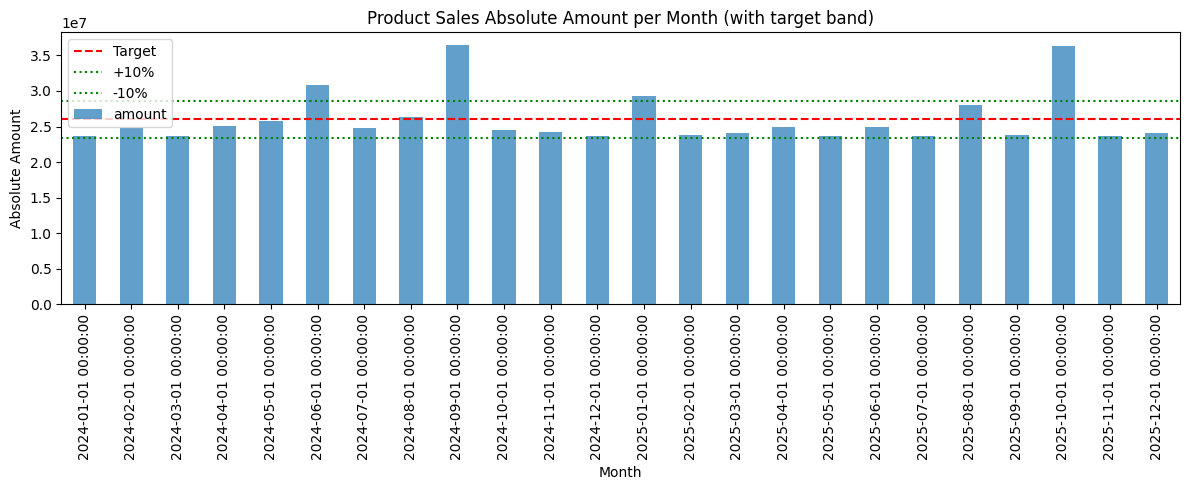

In [121]:
plot_monthly_with_target(df_even)

In [118]:
import matplotlib.pyplot as plt

def plot_sales_amount_over_time(df, title: str = "Sales Amount Over Time"):
    """
    Plots total sales ABSOLUTE AMOUNT by month and by quarter.
    Expects df to have df['date'] and df['amount'].
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    # keep only product rows
    df = df[df["product_id"].notna()]

    # --- aggregate per month (absolute amounts) ---
    df['month'] = df["date"].dt.to_period('M')
    monthly = df.groupby('month')["amount"].apply(lambda x: x.abs().sum())
    monthly.index = monthly.index.to_timestamp()

    # --- aggregate per quarter (absolute amounts) ---
    df['quarter'] = df["date"].dt.to_period('Q')
    quarterly = df.groupby('quarter')["amount"].apply(lambda x: x.abs().sum())
    quarterly.index = quarterly.index.to_timestamp()

    # --- plots ---
    plt.figure(figsize=(12,5))
    monthly.plot(kind='bar', alpha=0.7)
    plt.title("Product Sales Absolute Amount per Month")
    plt.ylabel("Absolute Amount")
    plt.xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    quarterly.plot(kind='bar', color='orange', alpha=0.7)
    plt.title("Product Sales Absolute Amount per Quarter")
    plt.ylabel("Absolute Amount")
    plt.xlabel("Quarter")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

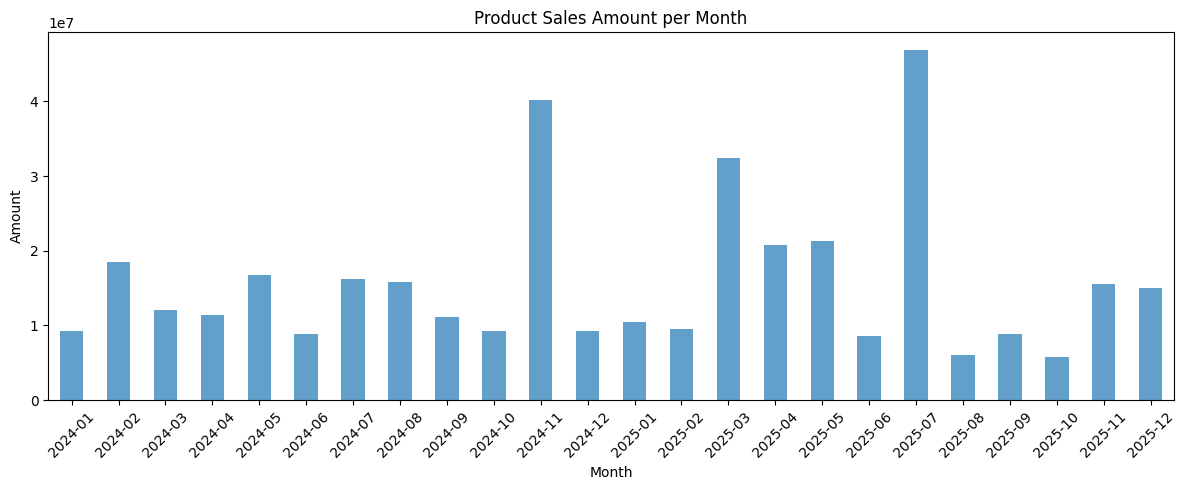

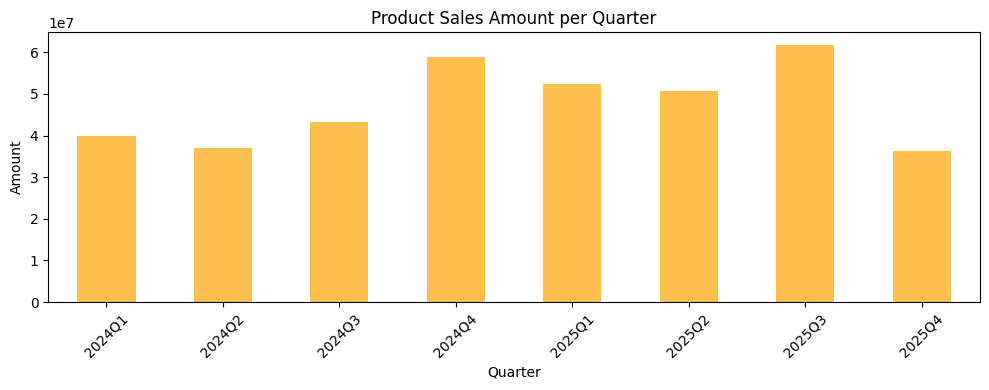

In [51]:
plot_sales_amount_over_time(data_products)

In [235]:
df_customers["customer_id"].max()

np.int64(64)

In [236]:
range = df_customers["customer_id"].max() - df_customers["customer_id"].min()

In [238]:
df = pd.DataFrame()
df["customer_id"] = df_customers["customer_id"].max()

In [239]:
df

,customer_id
